# Approach/Retreat classification for emoprox2 data

2-way classification using the following models:
- Gated Recurrent Unit (GRU)
- Temporal Convolutional Network (TCN)
- Feedforward Neural Network (FF)

In [1]:
import numpy as np
import pandas as pd
import pickle
import os

# plot
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
from plot_utils import _hex_to_rgb, _plot_ts
pio.orca.config.executable = '/home/joyneelm/fire/bin/orca'
colors = ["#D55E00", "#009E73", "#56B4E9", "#E69F00"]
clip_colors = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7",
    '#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb562', '#b3de69', '#fccde5']

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Parameters

In [2]:
class ARGS():
    roi_name = 'rvAI'
    near_miss = 1
    zscore = 0
    k_fold = 5
    batch_size = 32
    train_size = 42
    
    #gru
    gru_layers = 1
    gru_hidden = 32
    gru_epochs = 28
    
    #tcn
    tcn_wind = 10
    tcn_hidden = 25
    tcn_epochs = 50
    
    #ff
    ff_layers = 1
    ff_hidden = 103
    ff_epochs = 45

In [3]:
args = ARGS()

## Load results
Results used here are generated by the following files:
- clip_gru.py (GRU)
- clip_tcn.py (Temporal Convolutional Network)
- clip_ff.py (Feedforward Neural Network)

For architecture of each model, see corresponding files.

In [4]:
RES_DIR = {}
RES_DIR['ff'] = 'results/emo_ff'
RES_DIR['tcn'] = 'results/emo_tcn'
RES_DIR['gru'] = 'results/emo_gru'

## Visualization functions

In [5]:
def _get_results(args, model):
    
    if model=='gru':
        k_layers = args.gru_layers
        k_hidden = args.gru_hidden
        k_epochs = args.gru_epochs
    elif model=='ff':
        k_layers = args.ff_layers
        k_hidden = args.ff_hidden
        k_epochs = args.ff_epochs
    elif model=='tcn':
        k_wind = args.tcn_wind
        k_hidden = args.tcn_hidden
        k_epochs = args.tcn_epochs
    
    if model=='tcn':
        load_path = (RES_DIR[model] + 
                    '/%s_%d_net_%d' %(args.roi_name, args.roi, args.net) +
                    '_nw_%s' %(args.subnet) +
                    '_trainsize_%d' %(args.train_size) +
                    '_k_hidden_%d' %(k_hidden) +
                    '_k_wind_%d_batch_size_%d' %(k_wind, args.batch_size) +
                    '_num_epochs_%d_z_%d.pkl' %(k_epochs, args.zscore))
        
    else:
        load_path = (RES_DIR[model] + 
                    '/%s_near_miss_%d_trainsize_%d' %(args.roi_name,args.near_miss,args.train_size) +
                    '_kfold_%d_k_hidden_%d' %(args.k_fold, k_hidden) +
                    '_k_layers_%d_batch_size_%d' %(k_layers, args.batch_size) +
                    '_num_epochs_%d_z_%d.pkl' %(k_epochs, args.zscore))
    
    with open(load_path, 'rb') as f:
        results = pickle.load(f)
    
    return results

In [24]:
def get_ACCs(models, k_class, mode='train_mode', perf_type='acc'):
    '''
    accuracy matrix per participant per time
    perf_type : type of performance measure, 'acc' for accuracy, 'prob' for probability
    '''
    ACCs = []
    names = []
    for ii, m in enumerate(models):
        if m[0]=='ff':
            args.ff_layers = m[1]
        elif m[0]=='tcn':
            args.tcn_wind = m[1]
        elif m[0]=='gru':
            args.gru_layers = m[1]
                
        if perf_type is 'acc':
            
            r = _get_results(args, m[0])
            
            print(r.keys())
            
            if mode=='train_mode':
                acc = r['train_mode']['t_train']
            elif mode=='test_mode':
                acc = r['test_mode']['t_test']
                
        elif perf_type is 'prob':
            
            _, r_prob = _get_results(args, m[0])
            
            if mode=='train_mode':
                acc = r_prob['train']['t_prob']
            elif mode=='test_mode':
                acc = r_prob['test']['t_prob']
                
        name = m[2]
        names.append(name)
        
        max_clip_len = 0
        num_subjs = 0
        for idx_clip in range(k_class):
            acc_clip = acc[idx_clip]
            if type(acc_clip) is list: acc_clip = np.array(acc_clip)
            len_clip = acc_clip.shape[1]
            max_clip_len = max(max_clip_len, len_clip)
            num_subjs = acc_clip.shape[0]

        ACC = np.zeros((num_subjs, max_clip_len))
        N = np.zeros((num_subjs, max_clip_len))
        
        for idx_clip in range(k_class):
            
            acc_clip = acc[idx_clip]
            if type(acc_clip) is list: acc_clip = np.array(acc_clip)
            padding = np.zeros((num_subjs, max_clip_len - acc_clip.shape[1]))
            ACC += np.hstack([acc_clip, padding])
            N += np.hstack([np.ones(acc_clip.shape), padding])
            
        ACC /= N
        
        ACCs.append(ACC)
        
    return ACCs, names

def fig2A(ACCs, names, title, x_title):
    k_rows = 1
    k_cols = 1
    fig = make_subplots(rows=k_rows, cols=k_cols, 
        subplot_titles=[title], print_grid=False)
    
    for idx_model in range(len(ACCs)):
        
        ACC = ACCs[idx_model]
        name = names[idx_model]
        
        num_subjs = ACC.shape[0]

        ts = {'mean': np.mean(ACC, axis=0),
                    'ste': 1.96/np.sqrt(num_subjs) * np.std(ACC, axis=0)}
        
        showlegend = False        
        plotter = _plot_ts(ts, 0, colors[idx_model],
                        showlegend=showlegend, name=name, width=5)
        
        for trace in plotter:
            fig.add_trace(plotter[trace], 1, 1)
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=25,color='#000000')
    
    fig.update_layout(height=int(600*k_rows), width=800,
        legend_orientation='h', font=dict(size=18), yaxis_range=[0.4, 0.8])
    fig.update_xaxes(range=[0, ACCs[0].shape[1]], dtick=1, 
        title_text=x_title, title_font=dict(size=25), tickfont=dict(size=25),
        showgrid=False,
        autorange=False)
    fig.update_yaxes(range=[0, 1], dtick=0.05,
        gridwidth=1, gridcolor='#bfbfbf', title_font=dict(size=30), tickfont=dict(size=25),
        autorange=False)
    return fig

In [25]:
def fig2B(ACCs, names, title, censor_time=60):
    k_rows = 1
    k_cols = 1
    fig = make_subplots(rows=k_rows, cols=k_cols, 
        subplot_titles=[title], print_grid=False)
    
    for idx_model in range(len(ACCs)):
        
        ACC = ACCs[idx_model]
        name = names[idx_model]
        
        mean_ACC = np.mean(ACC, axis=0)
        mean_ACC = mean_ACC[censor_time:]
        
        showlegend = True 
        fillcolor = _hex_to_rgb(colors[idx_model]) + (0.3,)
        fillcolor = 'rgba' + str(fillcolor)
        trace = go.Violin(y=mean_ACC,
                            fillcolor=fillcolor,
                            line_color=colors[idx_model],
                            box_visible=True,
                            meanline_visible=True,
                            name=name,
                            showlegend=True)
        fig.add_trace(trace, 1, 1)
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=25,color='#000000')
    
    fig.update_layout(height=int(600*k_rows), width=800,
        legend_orientation='h', font=dict(size=18), title_font_size=30)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(range=[0, 1], dtick=0.2, 
        gridwidth=1, gridcolor='#bfbfbf',
        autorange=False)
    return fig

In [26]:
def window_on_ACC(ACCs, win_len):
    
    def moving_average(A, win_len) :
        ret = np.cumsum(A, axis=1, dtype=float)
        ret[:, win_len:] = ret[:, win_len:] - ret[:, :-win_len]
        return ret[:, win_len - 1:] / win_len
    
    ACCs_windowed = []
    for ACC in ACCs:
        ACCs_windowed.append(moving_average(ACC, win_len))
    
    return ACCs_windowed
        

dict_keys(['train_mode', 'test_mode'])


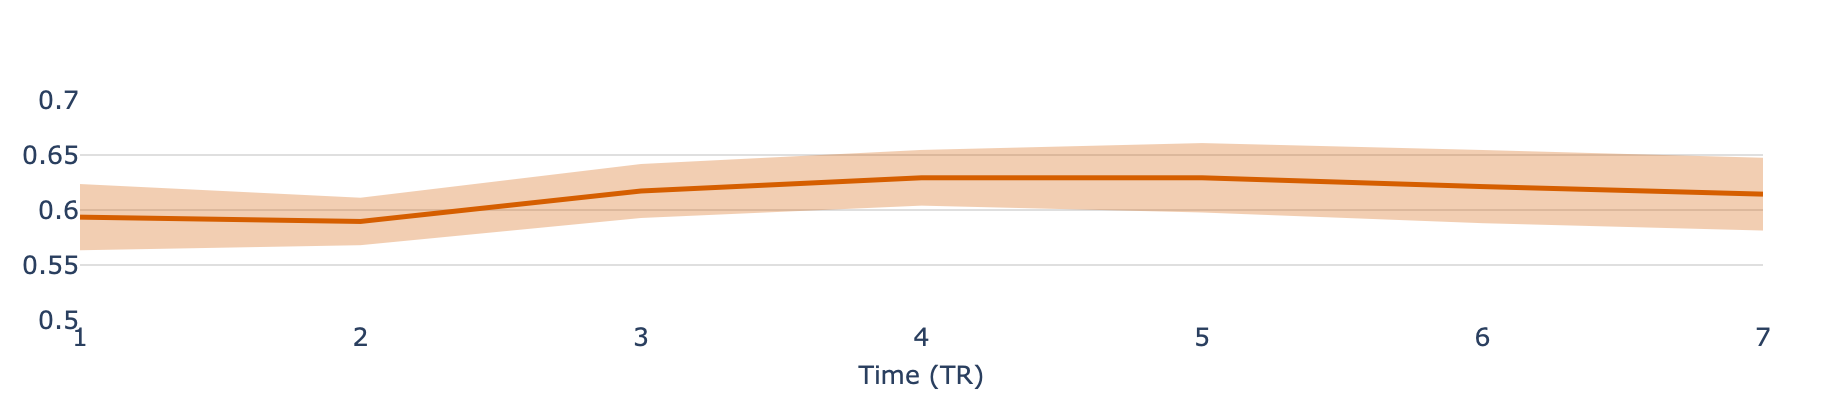

In [27]:
import plotly.io._orca
import retrying
unwrapped = plotly.io._orca.request_image_with_retrying.__wrapped__
wrapped = retrying.retry(wait_random_min=1000)(unwrapped)
plotly.io._orca.request_image_with_retrying = wrapped

perf_type = 'acc'
perf_name = {'acc':'Accuracy', 'prob':'Class Probability'}

models = [('gru', 3, 'GRU')]

ACCs, names = get_ACCs(models, k_class=2, mode='test_mode', perf_type=perf_type)

fig1 = fig2A(ACCs, names, title=f'', x_title='Time (TR)')
fig1.update_layout(yaxis_range=[0.5,0.7], xaxis_range=[1,7], height=400, width=800)
# fig2 = fig2B(ACCs, names, censor_time=60, title=f'{perf_name[perf_type]} Statistics across Time')
fig1.show()
# fig2.show()
fig1.write_image('figures/fig2_emo_r1c1.png')
# fig2.write_image('figures/fig2_r2c1.png')
# fig4.write_image('figures/fig2_r1c2.png')
# fig5.write_image('figures/fig2_r2c2.png')